<a href="https://colab.research.google.com/github/marissa-graham/deep_learning/blob/master/Final_project_architecture_and_tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install --no-cache-dir -I pillow # This line must be FIRST
!pip3 install torch torchvision tqdm
!pip3 install pillow==4.1.1

In [0]:
import PIL.Image

def register_extension(id, extension):
    PIL.Image.EXTENSION[extension.lower()] = id.upper()
PIL.Image.register_extension = register_extension

def register_extensions(id, extensions):
    for extension in extensions:
        register_extension(id, extension)
PIL.Image.register_extensions = register_extensions


import os
import csv
import glob
from collections import defaultdict

import seaborn
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, BatchSampler
from torchvision import models, transforms, utils, datasets

In [0]:
from google.colab import drive
#drive.mount('/content/gdrive')

# Make sure I've got drive mounted
glob.glob('/content/gdrive/My Drive/CS 501R/Final Project/*')

['/content/gdrive/My Drive/CS 501R/Final Project/Old Exams',
 '/content/gdrive/My Drive/CS 501R/Final Project/Summary of data available.gdoc',
 '/content/gdrive/My Drive/CS 501R/Final Project/metadata_finished.csv',
 '/content/gdrive/My Drive/CS 501R/Final Project/Graded Pages',
 '/content/gdrive/My Drive/CS 501R/Final Project/pleeeaaaase.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/test2.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/test100.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/test125.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/test72.png',
 '/content/gdrive/My Drive/CS 501R/Final Project/metadata.csv',
 '/content/gdrive/My Drive/CS 501R/Final Project/Score Labeled',
 '/content/gdrive/My Drive/CS 501R/Final Project/metadata_finished.gsheet',
 '/content/gdrive/My Drive/CS 501R/Final Project/Notes and Spec.gdoc',
 '/content/gdrive/My Drive/CS 501R/Final Project/501R final project.gsheet',
 '/content/gdrive/My Drive/CS 501R/Final Project/In

In [0]:
PARTIAL_BASE = '/content/gdrive/My Drive/CS 501R/Final Project/'

NEW_NAMES = {"W18 Exam 1":"W18_Exam1", "M112 F17 Final Exam":"F17_Final",
                "M112 W18 Final Exam":"W18_Final", "Math112Exam2":"F18_Exam2",
                "M112_Fall_2018_Midterm_1":"F18_Exam1", "F17 Exam2":"F17_Exam2",
                "Exam 2 Winter 2018":"W18_Exam2"}

def display_img(img):
    fig = plt.figure(figsize=(9,12))
    img = img.permute(1,2,0)
    plt.imshow(img.detach())
    plt.show()
        
def count_loaded():
    for _, folder in NEW_NAMES.items():
        base_name = PARTIAL_BASE + "Graded Pages/" + folder
        print(len(glob.glob(base_name + "/*.png")))

    print("Total:", len(glob.glob(PARTIAL_BASE + "Graded Pages/**/*.png", 
                                  recursive=True)))
    
def new_filename(original_filename):
    s = original_filename.replace(base_filename('Old Exams/'),"").rsplit('/')
    return "Graded Pages/" + NEW_NAMES[s[0]] + "/" + s[-1].replace(".pdf","")

def base_filename(extension=""):
    return '/content/gdrive/My Drive/CS 501R/Final Project/' + extension

def short_filename(filename):
    return filename.replace(base_filename(), "")

"\nwith open(base_filename('metadata_finished.csv'),'r') as f:\n    reader = csv.reader(f)\n    for (fname, source, stub, num, val, ignore, _) in reader:\n        if ignore == '0':\n            print(stub, '|||', new_filename(fname))\n"

In [0]:
class Graded112Dataset(Dataset):
    
    def __init__(self, height=256, width=512, score_labeled=False, 
                 cutoff_length=None):
        
        self.height = height
        self.cutoff_length = cutoff_length
        
        if score_labeled:
            extension = 'Score Labeled/'
        else:
            extension = 'Graded Pages/'
            
        self.image_folder = torchvision.datasets.ImageFolder(
            base_filename(extension), 
            transform = transforms.Compose([
                transforms.Resize((820,640)),
                transforms.CenterCrop((640,512)),
                transforms.Resize((int(2.5*height),width)),
                transforms.ToTensor()
            ])
        )
        
        # Construct question value dict
        if not score_labeled:
            self.get_question_values()
            self.scores = np.full(len(self.image_folder), -1)
        
        # Same for scores, if appropriate
        if score_labeled:
            self.get_question_values()
            self.get_scores()    
        
    def get_question_values(self):
    
        self.qvaldict= dict()
        with open(base_filename('metadata_finished.csv'), 'r') as f:
            reader = csv.reader(f)
            for (file, source, stub, num, val, ignore, reason) in reader:
                if ignore == '0':
                    self.qvaldict[new_filename(file)] = int(val)  
                    
        # And associated question value list
        self.qvals = np.zeros(len(self.image_folder))
        for i in range(len(self.image_folder)):
            fname = short_filename(self.image_folder.imgs[i][0])
            self.qvals[i] = self.qvaldict[fname.rsplit('_page')[0]]
        
    def get_scores(self):
        pass
        
    def __getitem__(self, i):
        """
        Return the image, the pts it's worth, and its score
        
        aka page, score, max_score
        """
        img = self.image_folder[i]
        
        # We only want the top bit
        return img[0].narrow(1, 0, self.height), -1, self.qvals[i]
    
    def __len__(self):
        """
        If you want to change the number used, just hard-code it here
        """
        if self.cutoff_length:
            return self.cutoff_length
        else:
            return len(self.image_folder)

### Test to make sure Graded112Dataset is working as expected


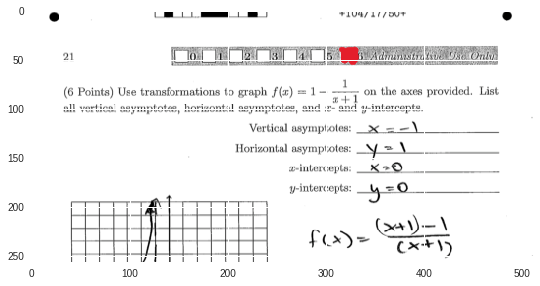

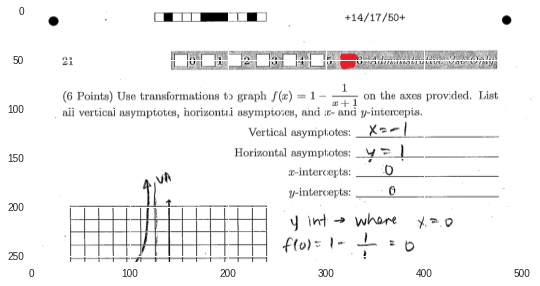

torch.Size([2, 3, 256, 512])
tensor([-1, -1])
tensor([6., 6.], dtype=torch.float64)


In [0]:
def test_dataset():
    dataset = Graded112Dataset(cutoff_length=100)

    n = len(dataset)
    split_ind = int(0.1*n)
    train_data, val_data = random_split(dataset, lengths=(n - split_ind, split_ind))

    train_loader = DataLoader(train_data, batch_size=2, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=2, shuffle=True)

    for batch_num, (pages, true_score, true_max) in enumerate(train_loader):
        for i in range(2):
            display_img(pages[i])
        print(pages.shape)
        print(true_score)
        print(true_max)
        break
        
test_dataset()

## Lab 3 architecture

In [0]:
class ConvNetwork(nn.Module):
    
    def __init__(self, c, H, W, output):
        
        super(ConvNetwork, self).__init__()
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(c, 10, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(10, 32, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 32, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 10, 3, stride=2, padding=1), 
            nn.ReLU()
        )
        self.linear =  nn.Linear(10*H*W//4, output)
        
    def forward(self, x):
        
        with_conv = self.conv_net(x)
        n, c, h, w = with_conv.size()
        return self.linear(with_conv.view(n, c*h*w))

## ResNet architecture

In [0]:
def conv3x3(in_filters, out_filters, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, infilters, filters, stride=1, downsample=None):
        
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(infilters, filters, stride)
        self.batchnorm1 = nn.BatchNorm2d(filters)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(filters, filters)
        self.batchnorm2 = nn.BatchNorm2d(filters)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        """
        Makes two layers; ReLU(F(x) + x), where F is two batchnormed conv layers
        """
        residual = x

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out
    
class myResNet(nn.Module):
    """
    Adapt the ResNet architecture to my image sizes.
    """
    def __init__(self, layers, height=256, width=512, num_classes=11):
        """
        block is "BasicBlock" or "Bottleneck"
        
        layers is length 4; how many layers do you want at each number of filters
        
        BatchNorm2d expects C from an expected input of size (N, C, H, W)
        
        Conv2d params: C_in, C_out, kernel, stride, padding
            input: (N, C_in, H, W)
            output: (N, C_out, H_out, W_out)
        
        *Pool2d params: k, s, p (default 0)
            input: (N, C, H, W)
            output: (N, C, H_out, W_out)
         
        H_out = floor( (H_in + 2*p - k)/s + 1 )
        W_out = floor( (W_in + 2*p - k)/s + 1 )
        """
        
        infilters = 64
        H = height
        W = width
        if H/32 != H//32 or W/32 != W//32:
            raise ValueError("Image dims must be divisible by 32")
        
        super(myResNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, infilters, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(infilters)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, 
                                    padding=1) # (N, infilters, H/4, W/4)
        
        self.layer1 = self._make_layer(infilters, infilters, 
                                       layers[0]) # (N, infilters, H/4, W/4)
        
        self.layer2 = self._make_layer(infilters, 2*infilters, layers[1], 
                                       stride=2) # (N, 2*infilters, H/8, W/8)
        
        self.layer3 = self._make_layer(2*infilters, 4*infilters, layers[2], 
                                       stride=2) # (N, 4*infilters, H/16, W/16)
                                       
        self.layer4 = self._make_layer(4*infilters, 8*infilters, layers[3], 
                                       stride=2) # (N, 8*infilters, H/32, W/32)
     
        self.avgpool = nn.AvgPool2d(kernel_size=(int(H/32), int(W/32)), 
                                   stride=1) # (N, 8*infilters, 1, 1)
            
        self.fc = nn.Linear(8*infilters, num_classes)

        # Initialize weights; normal dist. for Conv and zero for batchnorms
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, infilters, filters, blocks, stride=1):
        
        # Make sure the residual we're adding matches the output
        downsample = None
        if stride != 1 or infilters != filters:
            downsample = nn.Sequential(
                nn.Conv2d(infilters, filters,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(filters),
            )

        layers = []
        layers.append(BasicBlock(infilters, filters, stride, downsample))
        for i in range(1, blocks):
            layers.append(BasicBlock(filters, filters))

        return nn.Sequential(*layers)

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

## Main

In [0]:
def scope(H, W, cutoff_length, batch_size, num_epochs, val_batches, 
          model_type='resnet-18', learning_rate=1e-5):
    
    train_data = Graded112Dataset(height=H, width=W, 
                                     cutoff_length=cutoff_length)
    val_data = Graded112Dataset(height=H, width=W)
    
    output_classes = 11 # Scores from 0 to 10 (account for both score & maxpts)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size,
                            sampler=RandomSampler(val_data, replacement=True, 
                                            num_samples=batch_size*val_batches)
                           )
    n = len(train_loader)
    
    if model_type == 'resnet-18':
        model = myResNet([2,2,2,2], height=H, width=W).cuda() # resnet-18
    elif model_type == 'resnet-34':
        model = myResNet([3,4,6,3], height=H, width=W).cuda()
    elif model_type == 'Lab3':
        model = ConvNetwork(3, H, W, output_classes).cuda()

    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses, validations, train_accuracies, val_accuracies = [], [], [], []
    
    for epoch in range(num_epochs):
        
        print
        #loop = tqdm(total=n, position=0, leave=True)

        for batch, (pages, true_score, true_max) in enumerate(train_loader):
            
            print(true_max)
            """
            x, y_truth = pages.cuda(), true_max.cuda().long()
            optimizer.zero_grad()
            
            y_hat = model(x)
            loss = objective(y_hat, y_truth) # expected Long, got Double
            num_correct = torch.sum(y_truth == torch.argmax(y_hat,dim=1))
            a = float(num_correct) / float(batch_size)
            train_accuracies.append(a)

            loss.backward()
            losses.append(loss.item())

            s = "Epoch {}: loss {:.4f}, accuracy {:.3f}".format(epoch, loss, a)
            loop.set_description(s)
            loop.update(1)

            optimizer.step()
            """
            
            if batch % 10 == 0:
                
                """
                val = 0
                val_acc = 0
                loop2 = tqdm(total=val_batches, position=0, leave=True)
                """
                for i, (pgs, true_s, true_pts) in enumerate(val_loader):
                    
                    print("VAL", true_pts)
                    """
                    x, y_truth = pgs.cuda(), true_pts.cuda().long()
                    y_hat = model(x)
                    
                    loss = objective(y_hat, y_truth).item()
                    num_correct = torch.sum(y_truth==torch.argmax(y_hat,dim=1))
                    a = float(num_correct)/float(batch_size)
                    
                    s = 'Val {}/{}: loss {:.3f}, acc. {:.3f}'.format(i, 
                                                      val_batches, loss, a)
                    loop2.set_description(s)
                    loop2.update(1)
                    
                    print(np.round(loss, 2), ",", a)
                    val += loss/val_batches
                    val_acc += a/val_batches
                    
                validations.append((len(losses), val))
                val_accuracies.append((len(losses), val_acc))
                
                s = "Validation test {}/{}: loss {:.3f}, acc: {:.3f}".format(
                    batch//100+1, len(train_loader)//100 +1, val, val_acc)
                loop2.set_description(s)
                loop2.close()
                
                
        loop.close()
        print()
        """

    # Plot accuracy of training and validation set over time
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4.5))
    
    a, b = zip(*validations)
    ax1.plot(losses, label='train')
    ax1.plot(a, b, label='val')
    ax1.set_xlabel('Batch number')
    ax1.set_ylabel('Loss')
    ax1.set_title("Loss over {} epochs".format(num_epochs))
    ax1.legend()
    
    a, b = zip(*val_accuracies)
    ax2.plot(train_accuracies, label='train')
    ax2.plot(a, b, label='val')
    ax2.set_xlabel('Batch number')
    ax2.set_ylabel('Accuracy rate')
    ax2.set_title("Accuracy over {} epochs".format(num_epochs))
    ax2.legend()
    
    fig.suptitle("{} with {}x{} images, batch_size {}, images total".format(model_type,
                 H, W, batch_size, cutoff_length))
    plt.show()

# Experiments

In [0]:
import gc
gc.collect()

In [0]:
scope(H=32, W=64, cutoff_length=510, batch_size=5, num_epochs=3, 
      val_batches=5, model_type='resnet-18')

  0%|          | 0/102 [00:00<?, ?it/s]

tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
VAL tensor([6., 7., 7., 7., 6.], dtype=torch.float64)
VAL tensor([ 7.,  8., 10.,  8.,  6.], dtype=torch.float64)
VAL tensor([6., 6., 7., 6., 7.], dtype=torch.float64)
VAL tensor([6., 6., 6., 8., 8.], dtype=torch.float64)
VAL tensor([6., 8., 8., 8., 8.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
tensor([6., 6., 6., 6., 6.], dtype=torch.float64)
VAL tensor([8., 8., 7., 6., 6.], dtype=torch.float64)
VAL tensor([6., 7., 8., 7., 7.], dtype=torch.float64)
VAL tensor([7., 8., 8., 6., 6.], dtype=torch.float64)
VAL tensor([ 

KeyboardInterrupt: ignored

In [0]:
scope(H=64, W=128, cutoff_length=None, batch_size=8, num_epochs=1, 
      val_split=0.025, model_type='resnet-18')

len(dataset): 36766
919 images in validation dataset


Val 51/115: loss 2.387, acc. 0.000:  45%|████▌     | 52/115 [02:57<03:05,  2.94s/it]

KeyboardInterrupt: ignored

In [0]:
scope(H=64, W=128, cutoff_length=None, batch_size=12, num_epochs=1, 
      val_split=0.025, model_type='resnet-18')

len(dataset): 36766
919 images in validation dataset


Val 76/77: loss 2.698, acc. 0.000: 100%|██████████| 77/77 [06:15<00:00,  3.97s/it]

Avg val loss: 2.882, acc: 0.028


Epoch 0: loss 3.0115, accuracy 0.000:   0%|          | 7/2988 [06:55<20:21:47, 24.59s/it]

KeyboardInterrupt: ignored

In [0]:
scope(H=128, W=256, cutoff_length=10000, batch_size=4, num_epochs=1, 
      val_split=0.01, model_type='resnet-18')

In [0]:
scope(H=128, W=256, cutoff_length=10000, batch_size=8, num_epochs=1, 
      val_split=0.1, model_type='Lab3', learning_rate=1e-5)

# Before I fixed the cropping

In [0]:
scope(H=128, W=256, cutoff_length=10000, batch_size=8, num_epochs=1, 
      val_split=0.1, model_type='Lab3', learning_rate=1e-5)

  0%|          | 0/1125 [00:00<?, ?it/s]

len(dataset): 10000
1000 images in validation dataset


Val 124/125: loss 2.388, acc. 0.000: 100%|██████████| 125/125 [00:51<00:00,  2.46it/s]

Avg val loss: 2.385, acc: 0.000


Val 124/125: loss 0.938, acc. 0.750: 100%|██████████| 125/125 [00:53<00:00,  2.35it/s]

Avg val loss: 0.933, acc: 0.747


Val 124/125: loss 0.552, acc. 0.875: 100%|██████████| 125/125 [00:53<00:00,  2.36it/s]

Avg val loss: 0.770, acc: 0.747


Val 124/125: loss 0.946, acc. 0.625: 100%|██████████| 125/125 [00:52<00:00,  2.36it/s]

Avg val loss: 0.769, acc: 0.747


Val 124/125: loss 0.741, acc. 0.750: 100%|██████████| 125/125 [00:53<00:00,  2.24it/s]

Avg val loss: 0.742, acc: 0.747


Val 124/125: loss 0.974, acc. 0.625: 100%|██████████| 125/125 [00:53<00:00,  2.17it/s]

Avg val loss: 0.746, acc: 0.747


Val 124/125: loss 0.926, acc. 0.625: 100%|██████████| 125/125 [00:53<00:00,  2.26it/s]

Avg val loss: 0.741, acc: 0.747


Val 124/125: loss 0.886, acc. 0.625: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]

Avg val loss: 0.738, acc: 0.747


Val 124/125: loss 0.960, acc. 0.625: 100%|██████████| 125/125 [00:52<00:00,  2.40it/s]

Avg val loss: 0.742, acc: 0.747


Val 124/125: loss 0.992, acc. 0.625: 100%|██████████| 125/125 [00:54<00:00,  2.31it/s]

Avg val loss: 0.738, acc: 0.747


Val 109/125: loss 0.920, acc. 0.625:  88%|████████▊ | 110/125 [00:54<00:06,  2.33it/s]

KeyboardInterrupt: ignored

In [0]:
scope(H=128, W=256, cutoff_length=10000, batch_size=4, num_epochs=1, 
      val_split=0.01, model_type='resnet-18')

len(dataset): 10000
100 images in validation dataset


Val 24/25: loss 2.381, acc. 0.000: 100%|██████████| 25/25 [00:32<00:00,  1.33s/it]

Avg val loss: 2.481, acc: 0.000


Val 24/25: loss 1.154, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.17it/s]

Avg val loss: 1.398, acc: 0.730


Val 24/25: loss 0.722, acc. 1.000: 100%|██████████| 25/25 [00:05<00:00,  4.40it/s]

Avg val loss: 0.853, acc: 0.770


Val 24/25: loss 0.533, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.20it/s]

Avg val loss: 0.651, acc: 0.830


Val 24/25: loss 0.414, acc. 1.000: 100%|██████████| 25/25 [00:05<00:00,  4.14it/s]

Avg val loss: 0.544, acc: 0.840


Val 24/25: loss 0.512, acc. 0.750: 100%|██████████| 25/25 [00:06<00:00,  4.32it/s]

Avg val loss: 0.532, acc: 0.840


Val 24/25: loss 0.600, acc. 0.500: 100%|██████████| 25/25 [00:05<00:00,  4.11it/s]

Avg val loss: 0.436, acc: 0.820


Val 24/25: loss 0.481, acc. 0.750: 100%|██████████| 25/25 [00:05<00:00,  4.06it/s]

Avg val loss: 0.429, acc: 0.830


Val 24/25: loss 0.238, acc. 0.750: 100%|██████████| 25/25 [00:04<00:00,  5.57it/s]

Avg val loss: 0.332, acc: 0.890


Val 24/25: loss 0.051, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.26it/s]

Avg val loss: 0.373, acc: 0.870


Val 24/25: loss 0.247, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.40it/s]

Avg val loss: 0.254, acc: 0.910


Val 24/25: loss 0.189, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.61it/s]

Avg val loss: 0.238, acc: 0.930


Val 24/25: loss 0.479, acc. 0.750: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]

Avg val loss: 0.298, acc: 0.870


Val 24/25: loss 0.174, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.65it/s]

Avg val loss: 0.195, acc: 0.940


Val 24/25: loss 0.128, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.25it/s]

Avg val loss: 0.255, acc: 0.910


Val 24/25: loss 0.334, acc. 0.750: 100%|██████████| 25/25 [00:04<00:00,  5.40it/s]

Avg val loss: 0.181, acc: 0.950


Val 24/25: loss 0.162, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.30it/s]

Avg val loss: 0.209, acc: 0.940


Val 24/25: loss 0.073, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.43it/s]

Avg val loss: 0.196, acc: 0.950


Val 24/25: loss 0.819, acc. 0.750: 100%|██████████| 25/25 [00:04<00:00,  5.39it/s]

Avg val loss: 0.196, acc: 0.920


Val 24/25: loss 0.099, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.11it/s]

Avg val loss: 0.241, acc: 0.920


Val 24/25: loss 0.122, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.54it/s]

Avg val loss: 0.181, acc: 0.940


Val 24/25: loss 0.076, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.07it/s]

Avg val loss: 0.227, acc: 0.940


Val 24/25: loss 0.111, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.47it/s]

Avg val loss: 0.220, acc: 0.900


Val 24/25: loss 0.214, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.23it/s]

Avg val loss: 0.195, acc: 0.910


Val 24/25: loss 0.041, acc. 1.000: 100%|██████████| 25/25 [00:04<00:00,  5.31it/s]

Avg val loss: 0.205, acc: 0.910


Epoch 0: loss 0.0444, accuracy 1.000: 100%|██████████| 2475/2475 [1:10:19<00:00,  1.56s/it]

ValueError: ignored